##Tesla stock price prediction

The variables in the data

    Date,Open,High,Low,Close,Adj Close,Volume



In this project, I use an LSTM model to perform stock price prediction, as LSTM networks are particularly effective for sequential data and time series forecasting. Specifically, to predict the closing price of Tesla stock for a given day, the model takes the previous 20 days of stock prices as input. This sliding window approach is repeated across the dataset, enabling the model to learn temporal patterns. By the end of the process, we will have generated predictions for each day in the target period.


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [56]:
df_tesla_stocks=pd.read_csv('TSLA.csv')
df_tesla_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [57]:
def df_check(dataframe):
  print(f"shape of df:{dataframe.shape}\n")
  print(f"dtypes of df:{dataframe.dtypes}\n")#return the data type
  print(f"head of df:{dataframe.head}\n")
  print(f"tail of df:{dataframe.tail}\n")
  print(f"null of df:{dataframe.isnull().sum()}\n")
  print(f"info of df:{dataframe.info}\n")
  print(f"describe of df:{dataframe.describe().T}\n")

df_check(df_tesla_stocks)

shape of df:(2416, 7)

dtypes of df:Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

head of df:<bound method NDFrame.head of             Date        Open        High         Low       Close   Adj Close  \
0     2010-06-29   19.000000   25.000000   17.540001   23.889999   23.889999   
1     2010-06-30   25.790001   30.420000   23.299999   23.830000   23.830000   
2     2010-07-01   25.000000   25.920000   20.270000   21.959999   21.959999   
3     2010-07-02   23.000000   23.100000   18.709999   19.200001   19.200001   
4     2010-07-06   20.000000   20.000000   15.830000   16.110001   16.110001   
...          ...         ...         ...         ...         ...         ...   
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.799988  567.429993  580.989990  580.989990   
2413  2020-01-30  632.419983  650.880005 

###I saw that the data type of the "Date" column is an object.We need to convert this column to datetime format for proper time series analysis.

In [58]:
df_tesla_stocks["Date"]=pd.to_datetime(df_tesla_stocks["Date"])
print(df_tesla_stocks.dtypes)

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


###We are only retrieving the close prices and the corresponding dates.

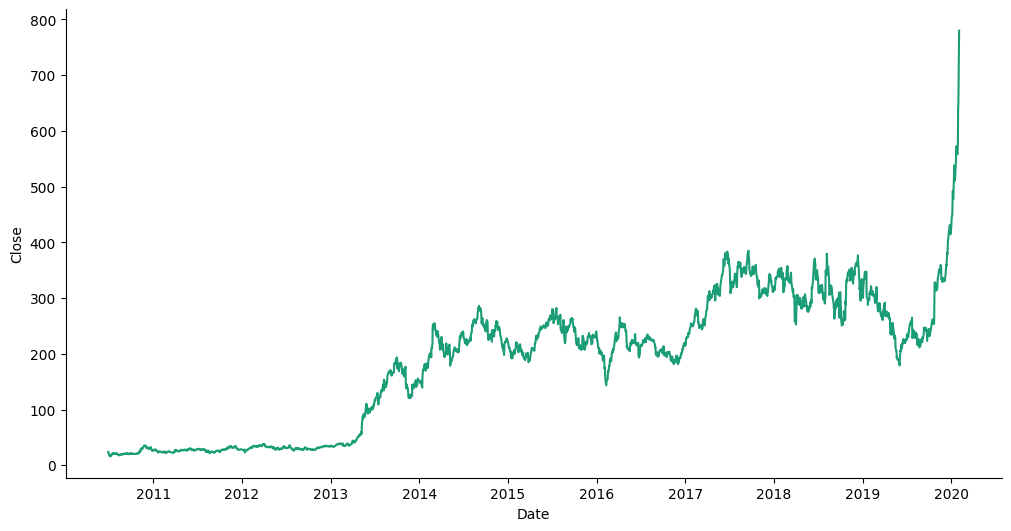

In [59]:
df_date_price=df_tesla_stocks[["Date","Close"]]
df_date_price.head()

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_date_price.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Close')

In [60]:
#min max prices
min_price=df_date_price["Close"].min()
min_price_date=df_date_price["Date"].min()
max_price=df_date_price["Close"].max()
max_price_date=df_date_price["Date"].max()
print(f"min price:{min_price}\nmax price:{max_price}")
print(f"min price date:{min_price_date}\nmax price date:{max_price_date}")

min price:15.8
max price:780.0
min price date:2010-06-29 00:00:00
max price date:2020-02-03 00:00:00


In [61]:
df_date_price.index=df_date_price["Date"]
df_date_price.drop("Date",axis=1,inplace=True)
print(df_date_price)

                 Close
Date                  
2010-06-29   23.889999
2010-06-30   23.830000
2010-07-01   21.959999
2010-07-02   19.200001
2010-07-06   16.110001
...                ...
2020-01-28  566.900024
2020-01-29  580.989990
2020-01-30  640.809998
2020-01-31  650.570007
2020-02-03  780.000000

[2416 rows x 1 columns]


In [62]:
df_date_price=df_date_price.values#pandas to numpy

In [63]:
print(df_date_price[0:5])#you can't use df_date_prices.head()

[[23.889999]
 [23.83    ]
 [21.959999]
 [19.200001]
 [16.110001]]


In [64]:
df_date_price=df_date_price.astype("float32")

###We can't use Scikit-learn's train_test_split function because it selects samples randomly, which is not suitable for time series data.

In [65]:
def split_data_for_lstm(dataframe, test_size):
    pos = int(len(dataframe) * (1 - test_size))
    train_data = dataframe[:pos]
    test_data = dataframe[pos:]
    return train_data, test_data, pos

train_dataset,test_dataset,pos=split_data_for_lstm(df_date_price,0.20)


In [66]:
MinMacSC=MinMaxScaler(feature_range=(0,1))
train_dataset=MinMacSC.fit_transform(train_dataset)
test_dataset=MinMacSC.transform(test_dataset)

print(train_dataset)

[[0.02191224]
 [0.02174973]
 [0.01668472]
 ...
 [0.90788186]
 [0.88640296]
 [0.85354817]]


##Create Features to Train the LSTM

In [67]:
def create_features(dataframe,timestep):
  x_train=[]
  y_train=[]
  for i in range(timestep,len(dataframe)):
    x_train.append(dataframe[i-timestep:i,0])
    y_train.append(dataframe[i,0])
  return np.array(x_train),np.array(y_train)

timestep=20
x_train,y_train=create_features(train_dataset,timestep)
x_test,y_test=create_features(test_dataset,timestep)


###We need to reshape these arrays into 3D format.

    (shape: (samples, timesteps, features))
            (x[0]   , x[1]       ,1      )

X_train.shape[0] - This is the number of samples. It corresponds to how many examples (rows/windows) you have created.

X_train.shape[1] - This is the number of time steps in each sample.
    

In [68]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

"""
for 2D
x_train=x_train.reshape(-1,1)
y_train=y_train.reshape(-1,1)

"""

'\nfor 2D\nx_train=x_train.reshape(-1,1)\ny_train=y_train.reshape(-1,1)\n\n'

#Modeling

In [69]:
modal=Sequential()
modal.add(LSTM(units=50,activation="relu",input_shape=(x_train.shape[1],1)))
modal.add(Dropout(0.2))#Prevents overfitting by randomly dropping 20% of neurons
modal.add(Dense(units=1))#Fully connected layer with 1 output


In [70]:
modal.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
modal.compile(loss='mean_squared_error',optimizer='adam')

In [72]:
callbacks= [EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode="min"),
              #Stops training if validation loss doesn't improve for 3 consecutive epochs
            ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',
                            save_best_only=True,verbose=1,save_weights_only=False)]
              #Saves the model with the lowest validation loss

In [73]:
history=modal.fit(x_train,y_train,epochs=100,batch_size=20,validation_data=(x_test,y_test),callbacks=callbacks,shuffle=False)
#Trains the model for 100 epochs using batch size of 20, with validation, and no shuffling

Epoch 1/100
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067
Epoch 1: val_loss improved from inf to 0.00586, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 2/100
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0191
Epoch 2: val_loss did not improve from 0.00586
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0190 - val_loss: 0.0063
Epoch 3/100
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0146
Epoch 3: val_loss improved from 0.00586 to 0.00491, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0145 - val_loss: 0.0049
Epoch 4/100
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059
Epoch 4: val_loss did not improve from 0.00491
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 5/100
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038
Epoch 5: val_loss did not improve from 0.00491
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 0.0070
Epoch 6/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021
Epoch 6: val_loss did not improve from 0.00491
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 6: early stopping


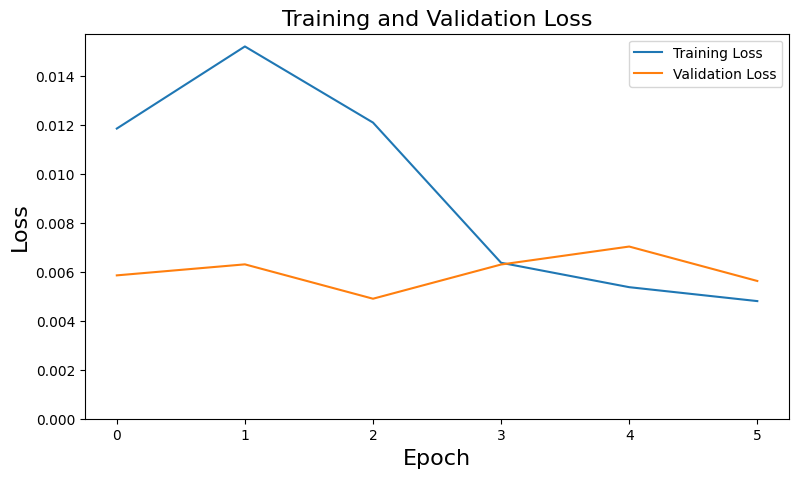

In [74]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

###Modal evaluation

In [75]:
loss=modal.evaluate(x_test,y_test,batch_size=20)
print("loss: %1.f%%"%(100.0 * loss))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
loss: 1%


In [76]:
train_predict=modal.predict(x_train)
test_predict=modal.predict(x_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [77]:
train_predict=MinMacSC.inverse_transform(train_predict)
test_predict=MinMacSC.inverse_transform(test_predict)

In [78]:
y_train=MinMacSC.inverse_transform(y_train.reshape(-1,1))
y_test=MinMacSC.inverse_transform(y_test.reshape(-1,1))

In [79]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))
print(f"train rmse:{train_rmse}\ntest rmse:{test_rmse}")

train rmse:26.459156734439897
test rmse:27.703780440286373


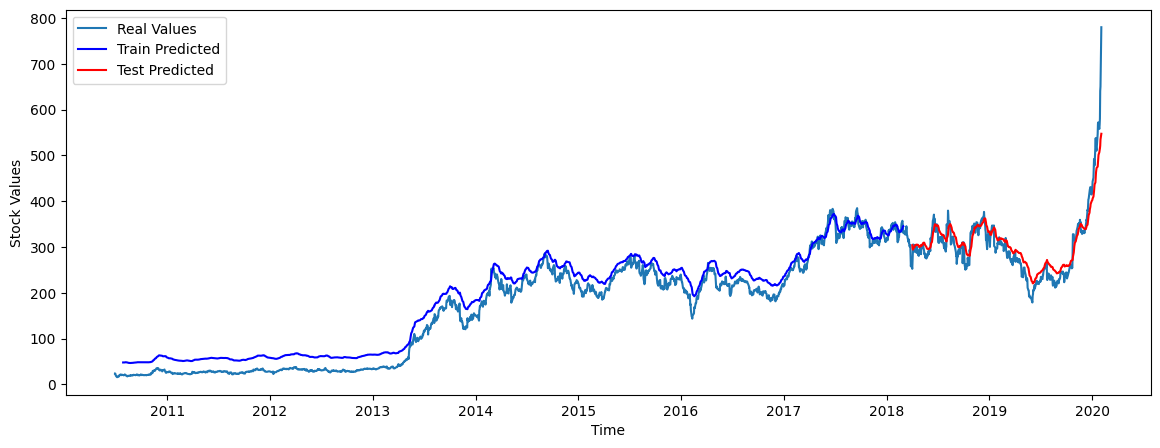

In [81]:
result_df = pd.DataFrame(df_date_price, columns=['Real Values'], index=df_tesla_stocks['Date'])
train_prediction_df = pd.DataFrame(train_predict, columns=['Predicted'], index=df_tesla_stocks['Date'][timestep:pos])
test_prediction_df = pd.DataFrame(test_predict, columns=['Predicted'], index=df_tesla_stocks['Date'][pos+timestep:])

plt.figure(figsize=(14, 5))
plt.plot(result_df, label='Real Values')
plt.plot(train_prediction_df["Predicted"], color='blue', label='Train Predicted')
plt.plot(test_prediction_df["Predicted"], color='red', label='Test Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()
